In [1]:
import os
import shutil
import sys

import glob
import tqdm

import NDH_Tools as ndh
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

import xarray as xr
import rioxarray as rxr

In [2]:
###########################################################
### Run a single file:
file_target = 'Data_20110507_02_019'


file_info = ndh.find_cresisfiles(file_target)
m_name, m_ind = ndh.str_compare(file_info['music_dirs'],'v2')
sp_name, sp_ind = ndh.str_compare(file_info['standard_dirs'],'standard_phase')
qp_name, qp_ind = ndh.str_compare(file_info['qlook_dirs'],'qlook_phase')

if len(sp_ind) > 0:
        if len(qp_ind) > 0:
            if len(m_ind) > 0:
                music_data = ndh.radar_load_music(file_info['music'][m_ind[0]])
                standardradar_data, standarddepth_data = ndh.radar_load(file_info['standard'][sp_ind[0]],0,2)
                qlookradar_data, qlookdepth_data = ndh.radar_load(file_info['qlook'][qp_ind[0]],0,2)

In [3]:
###########################################################
### Generate the Doppler Files
qdoppler_data = ndh.delay_doppler(qlookradar_data, window_size=300, target_ind=0, ind_spacing=50, deg0_or_rad1=0, return_fft=1)
sdoppler_data = ndh.delay_doppler(standardradar_data, window_size=300, target_ind=0, ind_spacing=50, deg0_or_rad1=0, return_fft=1)


row_inds = np.arange(5000,16000)
col_inds = [0,700]

############# Identifying the indecies for each dataset for the animation
### This is determined from the first doppler dataset
music_inds = ndh.find_nearest_xy(np.stack([music_data['x'],music_data['y']]).T,np.stack([standardradar_data['x'][row_inds],standardradar_data['y'][row_inds]]).T)
music_inds = np.unique(music_inds['index'])

delay_doppler_inds = ndh.find_nearest_xy(np.stack([sdoppler_data['x'],sdoppler_data['y']]).T,np.stack([standardradar_data['x'][row_inds],standardradar_data['y'][row_inds]]).T)
delay_doppler_inds = np.unique(delay_doppler_inds['index'])

target_ind = 11175;
music_target = ndh.find_nearest_xy(np.stack([music_data['x'],music_data['y']]).T,np.stack([standardradar_data['x'][target_ind:target_ind+1],standardradar_data['y'][target_ind:target_ind+1]]).T)
music_target = np.unique(music_target['index'])
dd_target = ndh.find_nearest_xy(np.stack([sdoppler_data['x'],sdoppler_data['y']]).T,np.stack([standardradar_data['x'][target_ind:target_ind+1],standardradar_data['y'][target_ind:target_ind+1]]).T)
dd_target = np.unique(dd_target['index'])

Center Frequency: 195000000.0


100%|██████████████████████████████████████| 1078/1078 [00:01<00:00, 686.95it/s]


Center Frequency: 195000000.0


100%|████████████████████████████████████████| 940/940 [00:06<00:00, 155.03it/s]


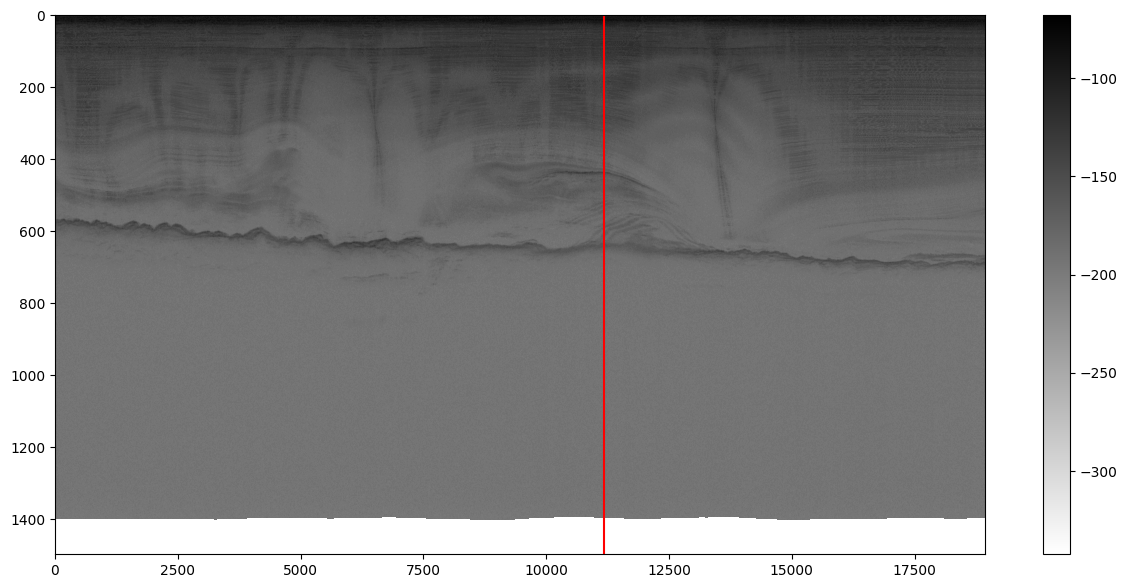

In [4]:
fig = plt.figure(figsize=(15,7))
imdata = plt.imshow(10*np.log10(np.real(standarddepth_data['new_data'])**2),
                    origin='lower',aspect='auto',cmap='gray_r')    
plt.axvline(target_ind,c='red')
cbar = plt.colorbar(imdata)
ax = plt.gca()
ax.invert_yaxis()


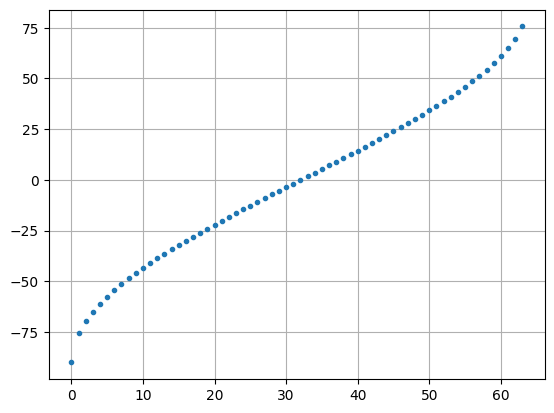

In [5]:
plt.plot(np.rad2deg(music_data['Tomo']['theta'][:,0,0]),'.')
plt.grid()

(1498, 64, 3155)


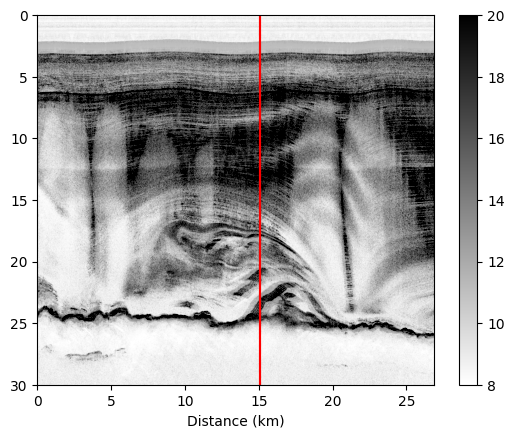

In [8]:
###############################
### The nadir Image
center_ind = 32
angle_range = 2
print(music_data['Tomo']['img'].shape)
theta_deg1 = np.rad2deg(music_data['Tomo']['theta'][:,0])[:,0]

dist_shift = music_data['distance'][music_inds[0]]/1000
cdata = plt.imshow(np.max(10*np.log10(music_data['Tomo']['img'][:,center_ind-angle_range:center_ind+angle_range+1,music_inds]),axis=1),
                   extent=[0,music_data['distance'][music_inds[-1]]/1000-dist_shift,music_data['Time'][0]*10**6,music_data['Time'][-1]*10**6]
                           ,origin='lower',cmap='gray_r',vmin=8,vmax=20)
plt.axvline(music_data['distance'][music_target]/1000-dist_shift,c='red')
plt.axvline(music_data['distance'][music_target]/1000-dist_shift,c='red')
plt.colorbar(cdata)
plt.gca().set_aspect('auto')
plt.ylim([30,0])
plt.xlabel('Distance (km)')
plt.savefig('Matplotlib_Fig1a.pdf')

22.024312837042164


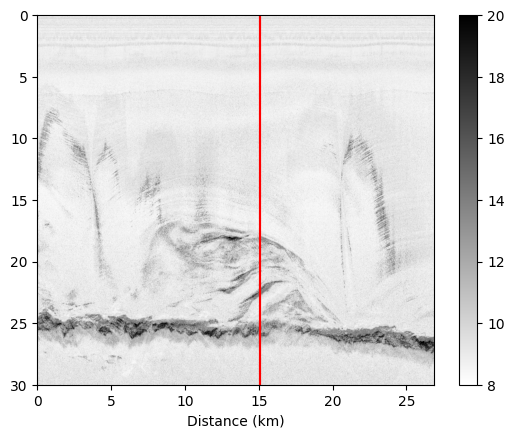

In [9]:
#######################################
### The off-nadir (x-track) image
center_ind = 32
shift = 12
angle_range = 2

cdata = plt.imshow(np.max(10*np.log10(
    np.concatenate([music_data['Tomo']['img'][:,center_ind-shift-angle_range:center_ind-shift+angle_range+1,music_inds],
                    music_data['Tomo']['img'][:,center_ind+shift-angle_range:center_ind+shift+angle_range+1,music_inds]],axis=1).squeeze()),axis=1),
                    extent=[0,music_data['distance'][music_inds[-1]]/1000-dist_shift,music_data['Time'][0]*10**6,music_data['Time'][-1]*10**6],
                    origin='lower',cmap='gray_r',vmin=8,vmax=20)
plt.axvline(music_data['distance'][music_target]/1000-dist_shift,c='red')
plt.axvline(music_data['distance'][music_target]/1000-dist_shift,c='red')
plt.colorbar(cdata)
plt.gca().set_aspect('auto')
plt.ylim([30,0])
plt.xlabel('Distance (km)')
plt.savefig('Matplotlib_Fig1b.pdf')

print(theta_deg1[center_ind+shift])

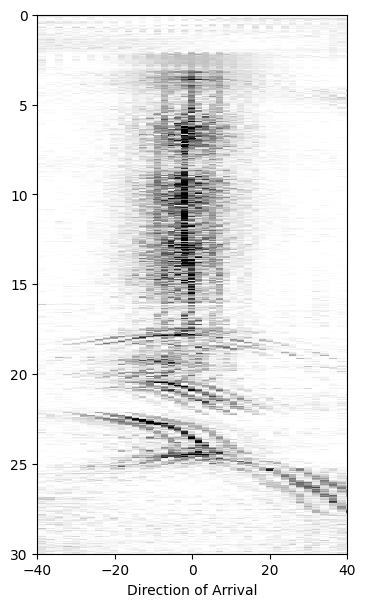

In [10]:
#######################################
### The off-nadir (x-track) image
plt.figure(figsize=(4,7))


imdata = plt.pcolor(theta_deg1, music_data['Time']*1e6,
                    10*np.log10(music_data['Tomo']['img'][:,:,music_target]).squeeze(),
                   cmap='gray_r',vmin=8,vmax=20)  
plt.colorbar(cdata)
plt.gca().set_aspect('auto')
plt.ylim([30,0])
plt.xlim([-40,40])
plt.xlabel('Direction of Arrival')
plt.savefig('Matplotlib_Fig1c.pdf')

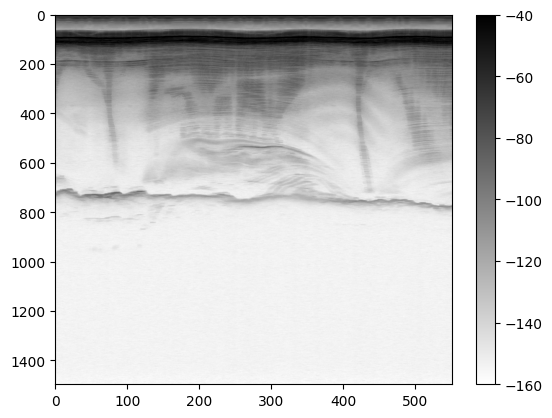

In [11]:
#######################################
### The nadir image (AT)
center_ind = int(sdoppler_data['doppler_data'].shape[2]/2)
shift = 12
angle_range = 20

cdata = plt.imshow(np.max(sdoppler_data['doppler_data'][delay_doppler_inds,:,center_ind-angle_range:center_ind+angle_range+1].squeeze().T,axis=0),
                   cmap='gray_r',vmin=-160,vmax=-40)
plt.colorbar(cdata)
plt.gca().set_aspect('auto')
#plt.ylim([30,0])

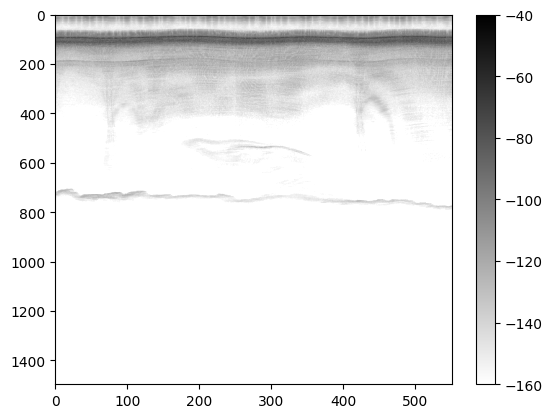

In [12]:
#######################################
### The nadir image (AT)
center_ind = int(sdoppler_data['doppler_data'].shape[2]/2)
shift = 60
angle_range = 10

cdata = plt.imshow(np.max(np.concatenate([sdoppler_data['doppler_data'][delay_doppler_inds,:,center_ind-shift-angle_range:center_ind-shift+angle_range+1],
                    sdoppler_data['doppler_data'][delay_doppler_inds,:,center_ind+shift-angle_range:center_ind+shift+angle_range+1]],axis=2).squeeze().T,axis=0),
                   cmap='gray_r',vmin=-160,vmax=-40)
plt.colorbar(cdata)
plt.gca().set_aspect('auto')
#plt.ylim([30,0])

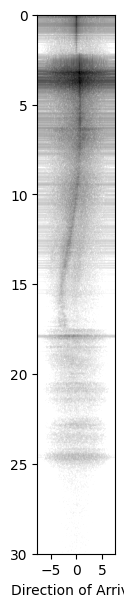

In [13]:

plt.figure(figsize=(1,7))
theta_deg3 = sdoppler_data['slope_axis']
imdata = plt.imshow(sdoppler_data['doppler_data'][dd_target,:,:].squeeze(),
                    extent=[theta_deg3[0],theta_deg3[-1],
                            sdoppler_data['Time'][0]*1e6,sdoppler_data['Time'][-1]*1e6],
                    origin='lower',aspect='auto',cmap='gray_r',vmin=-160,vmax=-40)   

plt.ylim([30,0])
plt.xlabel('Direction of Arrival')
plt.savefig('Matplotlib_Fig1d_v2.pdf')

In [14]:
!pwd

/mnt/NDH_data/Google_Drive2/Research_Projects/74_Multipass/TeX_Writeup_Petermann
